Note: Before running this document, make sure to turn on GPU by doing the following: Setting > Accelerator > GPU P100

Please also have a look at my GitHub for the **[Streamlit Application](https://github.com/nadzmi27/EmbeddingSearch)** 🥰
# Background
This notebook will explore how to make a **search engine using sentence embedding** (e.g. BERT) in two steps:
1. We will use **textual information** provided in the **[MyAnimeList](https://myanimelist.net/)** such as **synopsis, genre, demographic, and etc.** and transform them into **vector representation** and storing them into **[vector database](https://www.pinecone.io/learn/vector-database/)** (since the size of the data will be small, we will simply store them as numpy file). 
2. We will take in **query** by user and convert them into **vector representation** and match them to **top k** anime in the **vector database** using **Bi-Encoder** (explanation below) then we will narrow down the matches using **Cross-Encoder**. The ranking of the matches is decided with the combination of **score, popularity and favorites** using **[geometric mean](https://en.wikipedia.org/wiki/Geometric_mean)**.


## Bi-Encoder vs Cross-Encoder
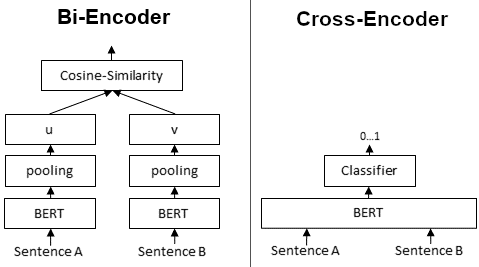 

Image source: [Bi-Encoder vs Cross-Encoder](https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/docs/img/Bi_vs_Cross-Encoder.png)

- **Bi-Encoder:** Uses separate encoders for each input, making it efficient and scalable for tasks like similarity search. However, it might miss detailed interactions between inputs.
    - Note: We are not limited to using Cosine-Similarity, we can also use clustering algorithm such as K-Means and Agglomerative Clustering.
- **Cross-Encoder:** Processes both inputs together, capturing interactions more effectively and often providing better accuracy, but can be computationally intensive and less scalable.


# Strengths and Limitations
**Strengths:**
- Can search anime based on context similarity and semantic understanding rather than words similarity (e.g. TF-IDF and BM25). This allow the search engine to take synonyms and similar phrasings into account, even providing match when there is no word in common between query and textual information. This helps alleviate the need of using specific to get great match. 
- Efficiently handle large-scale datasets and provide fast similarity searches even with high-dimensional data. The contextual information is stored in vector representation, to find similarity we can simply use algorithm that calculate distance between vectors.

**Limitations:**
- The quality of the search engine highly-depends on the textual information provided. If information doesn't provide anything about specific character, user won't be able to search for anime containing that character; e.g. 'Lizard Man' won't return the anime 'Dorohedoro'. This limitation can be overome by combining textual information from multiple source and using encoder with longer input tokens, but I'll svae this for another time. 
- It is not a recommendation system. It simply match user query to anime information.
- Deep learning models can be computationally expensive to train and deploy, requiring significant hardware resources, especially for large-scale applications.


# Use Cases
What we explored is **not limited to textual data**, we can also use them for **images, audio, and even the combination of different data type** here are few ways we can use the concept:
1. **Multimedia (text, audio, image) Retrieval:** Match query (text) to text,audio,image. Or even match image/audio to text,audio,image. You get the point.
2. **Question Answering:** Provide accurate answers to user queries based on document content.
3. **Recommendation Systems:** Suggest items based on user preferences and similar items.
4. **Content Personalization:** Tailor content recommendations based on user interests and behavior.
5. **Duplicate Detection:** Find similar or duplicate documents within a dataset.
6. **Anything that involves matching**: Literally anything or at least majority of tasks that involve matching process can be done using encoding and vector database.

# Install and Import Libraries

In [1]:
# Install required libraries
!pip install -q sentence-transformers

In [2]:
# Import libraries
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # Linear algebra
from scipy import stats # For minmax scaler
from tqdm.autonotebook import tqdm # Progress bar
from sentence_transformers import SentenceTransformer, CrossEncoder, util # Sentence embedding and similarity
from transformers import pipeline, AutoTokenizer, AutoModel # Checing context length and summarizer
import torch
import seaborn as sns # Data visualisation
import ast # To convert string into correct datatype (e.g. "[1,2,3]" into list of [1,2,3])

tqdm.pandas() # Allow pandas integration of tqdm

/tmp/ipykernel_34/2522487070.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm # Progress bar
2024-08-11 03:00:31.753156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 03:00:31.753277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 03:00:31.877723: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Download Model
> List of available bi-encoder can be found [here](https://sbert.net/docs/sentence_transformer/pretrained_models.html).

In [3]:
# Checking if gpu is available. If available set device to gpu, otherwise cpu
if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")
    
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
# We will use bi_encoder available from Sentence Transformer library
bi_encoder_name = 'all-distilroberta-v1' # 512 max sequence length
bi_encoder = SentenceTransformer('all-distilroberta-v1')
top_k = 100 #Number of passages we want to retrieve with the bi-encoder

# Download tokenizer for the bi_encoder
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/'+bi_encoder_name, device_map=device)

#The bi-encoder will retrieve 100 documents. We use a cross-encoder, to re-rank the results list to improve the quality
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# Summarizer for anime sypnopsis/description longer than 512 context length
summarizer = pipeline("summarization", model="Falconsai/text_summarization", device_map=device) # Small and quick summarizer

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

# Import Dataset

In [5]:
# Read dataset
path = '/kaggle/input/my-anime-list-scraped-dataset/top_animes_after_cleaning.csv'
anime = pd.read_csv(path)

In [6]:
anime.head(2)

,Japanese,Type,Episodes,Status,Aired,Premiered,Producers,Licensors,Studios,Source,...,Favorites,description,Name,English Name,Recommended,Mixed Feelings,Not Recommended,Themes,Demographics,Seasonal
0,葬送のフリーレン,TV,28,Finished Airing,"Sep 29, 2023 to Mar 22, 2024",Fall 2023,"Aniplex, Dentsu, Shogakukan-Shueis...","None found, add some",Madhouse,Manga,...,43111,During their decade-long quest to defeat the D...,Sousou no Frieren,Frieren: Beyond Journey's End,493,67,42,['Unknown-Themes'],['Shounen'],False
1,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,Finished Airing,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,"Aniplex, Square Enix, Mainichi Bro...","Funimation, Aniplex of America",Bones,Manga,...,226182,After a horrific alchemy experiment goes wrong...,Fullmetal Alchemist: Brotherhood,NaN,912,59,39,['Military'],['Shounen'],False


In [7]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15262 entries, 0 to 15261
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Japanese         15047 non-null  object 
 1   Type             15262 non-null  object 
 2   Episodes         15262 non-null  object 
 3   Status           15262 non-null  object 
 4   Aired            15262 non-null  object 
 5   Premiered        5527 non-null   object 
 6   Producers        15262 non-null  object 
 7   Licensors        15262 non-null  object 
 8   Studios          15253 non-null  object 
 9   Source           15262 non-null  object 
 10  Genres           15262 non-null  object 
 11  Duration         15262 non-null  object 
 12  Rating           15262 non-null  object 
 13  Score            15262 non-null  float64
 14  Ranked           15262 non-null  int64  
 15  Popularity       15262 non-null  int64  
 16  Members          15262 non-null  int64  
 17  Favorites   

Missing values in Japanese, Premiered, and English Name

In [8]:
# Capitalize the columns name
anime.rename(columns={'description':'Description'}, inplace=True)
anime.columns = anime.columns.str.replace(' ', '')

In [9]:
anime.columns

Index(['Japanese', 'Type', 'Episodes', 'Status', 'Aired', 'Premiered',
       'Producers', 'Licensors', 'Studios', 'Source', 'Genres', 'Duration',
       'Rating', 'Score', 'Ranked', 'Popularity', 'Members', 'Favorites',
       'Description', 'Name', 'EnglishName', 'Recommended', 'MixedFeelings',
       'NotRecommended', 'Themes', 'Demographics', 'Seasonal'],
      dtype='object')

## Filter Anime

In [10]:
# Select variables that are important and only use anime that are scored higher than average
# mean_score = anime.Score[anime.Score > 0].mean()
# cutoff = np.argmax(anime.Score < mean_score)

# Keep this for the final use
anime_columns_filtered = anime[['Name', 'EnglishName', # Name
                        'Description', 'Type','Genres', 'Demographics', 'Episodes', 'Themes', # Description about the anime
                        'Score', 'Ranked', 'Popularity', 'Members', 'Favorites' # Metrics
                       ]]

# This for adding new columns and modification
anime_filtered = anime_columns_filtered.copy()

# Quick EDA

In [11]:
# Run this first before using ydata_profiling. This will take awhile
# !conda install -qy numba==0.58.1

In [12]:
# # Uncomment to run
# from ydata_profiling import ProfileReport

# # Define the profile report
# # profile = ProfialeReport(anime_filtered, title="Profiling Report", html={'style':{'full_width':True}})
# profile = ProfileReport(anime_filtered, title="Profiling Report")

# # Show the profile report
# profile

# Dataset Modification For Embedding

In [13]:
# Drop duplicated rows
anime_filtered = anime_filtered.drop_duplicates()

# Remove return + new line and "[Written by MAL Rewrite]"
anime_filtered.Description = anime_filtered.Description.map(lambda p: p.replace("\r\n", "\n"))
anime_filtered.Description = anime_filtered.Description.map(lambda p: p.replace("[Written by MAL Rewrite]", '').strip())

# Convert unknown to NaN and convert column data type to numerical
anime_filtered.Episodes = anime_filtered.Episodes.replace('Unknown', np.nan).astype(np.float32)

# Add variable sequence length. Bi-encoder have maximum sequence length. We will summarize description with long sequence length
anime_filtered['SeqLength'] = anime_filtered.Description.progress_map(lambda d: len(tokenizer(d)['input_ids']))

  0%|          | 0/15259 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# Get the title of the anime, English Name if it exist, otherwise it's original name
def get_title(row):
    if isinstance(row.EnglishName, str):
        return row.EnglishName
    else:
        return row.Name

title = anime_filtered.apply(lambda x: get_title(x), axis=1)
anime_filtered.insert(2, 'Title', title)

In [24]:
# Function for improving the description. 
# Adding Name, Title, Genres, Demographics, Themes and Episodes on top of sypnopsis
# TODO: Add type, 
def improve_desc(row, summarizer=summarizer, seqlength=420):
    infos = ''
    if row.Title:
        infos += "Title:" + row.Title
    if row.Type:
        infos += "\nType:" + row.Type
    if row.Genres != "['Unknown-Genre']":
        infos += "\nGenres: " + ', '.join(ast.literal_eval(row.Genres))
    if row.Demographics != "['Unknown-Demographic']":
        infos += "\nDemographics: " + ', '.join(ast.literal_eval(row.Demographics))
    if row.Themes != "['Unknown-Themes']":
        infos += "\nThemes: " + ', '.join(ast.literal_eval(row.Themes))
    if not np.isnan(row.Episodes):
        infos += "\nTotal Episodes: " + str(int(row.Episodes))
    
    description = row.Description.replace("[Written by MAL Rewrite]", '').strip()
    if row.SeqLength > seqlength:
        description = summarizer(description, max_length=300, min_length=100, do_sample=False)[0]['summary_text']
        
    description = infos + '\n\nSynopsis:\n' + description
    return description

In [25]:
# MinMax Scaler to restrict value between 0 and 1
def minmax_scaler(col, invert=False, boxcox=False):
    arr = col.to_numpy()
    if boxcox:
        mn = arr.min()
        if mn <= 0:
            arr += -mn + 1 # Make the data positive and non-zero
        arr = stats.boxcox(arr)[0]
    if invert:
        arr = -arr
    mx = arr.max()
    mn = arr.min()
    return (arr - mn)/(mx - mn)

# Restrict score value to 0-1
anime_filtered['ScoreScaled'] = anime_filtered['Score'].map(lambda x: x/10)
anime_filtered['RankedScaled'] = minmax_scaler(anime_filtered['Ranked'], invert=True) # Lower is better
anime_filtered['PopularityScaled'] = minmax_scaler(anime_filtered['Popularity'], boxcox=True, invert=True) # Lower is better
anime_filtered['FavoritesScaled'] = minmax_scaler(anime_filtered['Favorites'], boxcox=True) 

In [26]:
# This will take awhile without cuda (gpu) activated
anime_filtered['DescriptionAugmented'] = anime_filtered.progress_apply(lambda row: improve_desc(row), axis=1)

  0%|          | 0/15259 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


# Sentence Embeddings and Semantic Finder

In [27]:
# Convert description into embeddings (vector space)
corpus = anime_filtered.DescriptionAugmented.to_list()
convert_to_tensor = (device == 'cuda:0')
corpus_embeddings = bi_encoder.encode(corpus, convert_to_tensor=convert_to_tensor, show_progress_bar=True)

Batches:   0%|          | 0/477 [00:00<?, ?it/s]

In [28]:
def semantic_search(query, corpus_embeddings=corpus_embeddings, n_rows=5000, top_k=top_k):
    # Encode the query using the bi-encoder and find potentially relevant description
    if device == 'cuda:0':
        question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
        question_embedding = question_embedding.cuda()
    else:
        question_embedding = bi_encoder.encode(query, convert_to_tensor=False)
        
    hits = util.semantic_search(question_embedding, corpus_embeddings[:n_rows], top_k=top_k)
    hits = hits[0]
    
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, corpus[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)
    
    # Include cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]
    return hits

In [29]:
# Function for adding weights to the hits
def add_weight(n_rows=5000):
    # Restrict score value to 0-1
    score_scaled = anime_filtered['Score'].iloc[:n_rows].map(lambda x: x/10)
    popularity_scaled = minmax_scaler(anime_filtered['Popularity'].iloc[:n_rows], boxcox=True, invert=True) # Lower is better
    favorites_scaled = minmax_scaler(anime_filtered['Favorites'].iloc[:n_rows], boxcox=True)
    
    # W1 is the geometric mean of ScoreScaled and PopularityScaled
    # W2 is the geometric mean of ScoreScaled, PopularityScaled, and FavoritesScaled
    # Favorite is correlated with Popularity
    
    w1 = score_scaled*popularity_scaled
    w2 = w1*favorites_scaled

    w1 = np.sqrt(w1)
    w2 = np.cbrt(w2)

    return w1, w2

# Function for filtering the hits
def hits_filter(hits, n_rows=5000, n=6, cs_threshold=-8):
    w1, w2 = add_weight(n_rows)
    
    for i in range(len(hits)):
        hits[i]['w1'] = w1[hits[i]['corpus_id']]
        hits[i]['w2'] = w2[hits[i]['corpus_id']]
    
    #
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    cs = [x['corpus_id'] for x in hits[:n] if x['cross-score'] >= cs_threshold]
    csmin = hits[-1]['cross-score']
    
    hits = sorted(hits, key=lambda x: (x['cross-score'] - csmin + 0.1)*x['w1'], reverse=True)
    csw1 = [x['corpus_id']for x in hits[:n] if x['cross-score'] >= cs_threshold]

    hits = sorted(hits, key=lambda x: (x['cross-score'] - csmin + 0.1)*x['w2'], reverse=True)
    csw2 = [x['corpus_id'] for x in hits[:n] if x['cross-score'] >= cs_threshold]
    
    #
    hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    s = [x['corpus_id'] for x in hits[:n] if x['cross-score'] >= cs_threshold]
    
    hits = sorted(hits, key=lambda x: x['score']*x['w1'], reverse=True)
    sw1 = [x['corpus_id'] for x in hits[:n] if x['cross-score'] >= cs_threshold]

    hits = sorted(hits, key=lambda x: x['score']*x['w2'], reverse=True)
    sw2 = [x['corpus_id'] for x in hits[:n] if x['cross-score'] >= cs_threshold]
    
    # Combine
    ss = set(sw1).union(sw2).union(s)
    css = set(csw1).union(csw2).union(cs)
    combined = list(ss.union(css))
    
    return combined
#     return cs, csw1, csw2, s, sw1, sw2

In [31]:
# Testing function
def find_hit(hits, idx):
    for i in range(len(hits)):
        if hits[i]['corpus_id'] == idx:
            print(hits[i])
            print()
            print(anime_filtered.iloc[idx].DescriptionAugmented)
            return None
    return "Not in the list"

Query to test:
1. Time travelling
2. Mystery time travel
3. Ping pong
4. Superhero anime
5. Anime where the main character is a villain

In [32]:
def find_anime(query, sort_rank=False, corpus_embeddings=corpus_embeddings, n_rows=5000, top_k=top_k, n=6, cs_threshold=-8):
    hits = semantic_search(query, corpus_embeddings, n_rows, top_k)
    idx = hits_filter(hits, n_rows, n, cs_threshold)
    if sort_rank:
        return anime_columns_filtered.iloc[idx].sort_values("Score", ascending=False)
    else:
        df = pd.DataFrame(hits)
        cs_min = df["cross-score"].min()
        df = df[df.corpus_id.isin(idx)]
        idx = np.argsort((df['cross-score'] - cs_min + 0.1)*df['w2'])[::-1]
        df = df.iloc[idx]
        idx = df.corpus_id
        return anime_columns_filtered.iloc[idx]

# Demo

In [33]:
import ipywidgets as widgets
from IPython.display import display, clear_output

In [64]:
style = {'description_width': 'initial'}

# Text bar
text_input = widgets.Text(value='', placeholder='E.g. Time travel murder mystery',
                          description='Anime Description:', disabled=False, style=style)

# First Slider for top n-th anime 
slider1 = widgets.IntSlider(value=3000, min=100, max=anime_filtered.shape[0], step=10,
                            description='Top n-th Anime:', continuous_update=False, style=style)

# Second Slider for top k retrieved Bi-Encoder embeddings
slider2 = widgets.IntSlider(value=100, min=50, max=slider1.value, step=10,
                            description='Top k embeddings',continuous_update=False, style=style)

# Update the max value of slider2 when slider1 changes
def update_slider2_max(*args):
    slider2.max = slider1.value
    if slider2.value > slider1.value:
        slider2.value = slider1.value

slider1.observe(update_slider2_max, 'value')

# Third Slider for the number (n) of k retrieved candidates list from Bi-Encoder. For Cross-Encoder
slider3 = widgets.IntSlider(value=6, min=1, max=100, step=1,
                            description='',continuous_update=False, style=style, 
                            layout=widgets.Layout(width='185px'))
slider3_desc = widgets.HTML(value="No. of candidates</br>for Cross-Encoders:")

hbox3 = widgets.HBox([slider3_desc, slider3])

# Fourth slider for the minimum value of Cross-Encoder score
slider4 = widgets.FloatSlider(value=-8.0, min=-15, max=15, step=0.1,
                              description='',continuous_update=False, style=style,
                              layout=widgets.Layout(width='173px'))
    
slider4_desc = widgets.HTML(value="Cross-Encoder score</br>(lower is less filtered):")

hbox4 = widgets.HBox([slider4_desc, slider4])

# Checkbox for sorting by rank
checkbox = widgets.Checkbox(value=False, description='Sort by rank (MAL Score)', 
                            continuous_update=False, style=style)

# Number input for display limit
number_input = widgets.IntText(value=10, min=0, description="Display Limit",
                        continuous_update=False, style=style)

# Button for finding the anime
button = widgets.Button(description='Submit', disabled=False, tooltip='Click me',icon='check')

# Output widget to display the DataFrame
output = widgets.Output()

# Function to handle button click event
def on_button_click(b):
    with output:
        # Clear previous output
        clear_output()

        # Process the input values
        query = text_input.value
        n_rows = slider1.value
        top_k = slider2.value
        n = slider3.value
        cs = slider4.value
        sort_rank = checkbox.value

        # Create a pandas DataFrame based on the input values
        df = find_anime(query, sort_rank=sort_rank, corpus_embeddings=corpus_embeddings, n_rows=n_rows, top_k=top_k, n=n, cs_threshold=cs)

        # Display the DataFrame
        display(df.head())

# Attach the event handler to the button
button.on_click(on_button_click)

# Display the interactive elements
display(text_input, slider1, slider2, hbox3, hbox4, checkbox, number_input, button, output)


Text(value='', description='Anime Description:', placeholder='E.g. Time travel murder mystery', style=Descript…

IntSlider(value=3000, continuous_update=False, description='Top n-th Anime:', max=15259, min=100, step=10, sty…

IntSlider(value=100, continuous_update=False, description='Top k embeddings', max=3000, min=50, step=10, style…

Checkbox(value=False, description='Sort by rank (MAL Score)', style=DescriptionStyle(description_width='initia…

IntText(value=10, description='Display Limit', style=DescriptionStyle(description_width='initial'))

Button(description='Submit', icon='check', style=ButtonStyle(), tooltip='Click me')

Output()

# Download The Dataset and Embedding

In [65]:
# np.save("CorpusEmbeddings", corpus_embeddings.cpu().numpy())
anime_filtered.to_csv("AnimeFiltered.csv", index=False)

In [67]:
# Split into 3 for GitHub upload later
ce = corpus_embeddings.cpu()
ce1 = ce[:5000]
ce2 = ce[5000:10000]
ce3 = ce[10000:]
np.save("CE1.npy", ce1)
np.save("CE2.npy", ce2)
np.save("CE3.npy", ce3)